# 1 Initialisation

## 1.1 Installation & Load Libraries

In [1]:
!pip install lazypredict

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 269 kB 7.3 MB/s 
     |████████████████████████████████| 1.2 MB 43.5 MB/s 
     |████████████████████████████████| 25.9 MB 2.6 MB/s 
     |████████████████████████████████| 14.5 MB 38.5 MB/s 
     |████████████████████████████████| 10.1 MB 28.1 MB/s 
     |████████████████████████████████| 248 kB 37.5 MB/s 
     |████████████████████████████████| 6.8 MB 20.9 MB/s 
     |████████████████████████████████| 302 kB 28.7 MB/s 
     |████████████████████████████████| 72 kB 1.1 MB/s 
     |████████████████████████████████| 127.6 MB 16 kB/s 
  Created wheel for PyYAML: filename=PyYAML-5.3.1-cp37-cp37m-linux_x86_64.whl size=44636 sha256=49b2b5a1235f4b5429729fca5683e35ab4abb17195ccb3dbebccb9346527b2a7
  Stored in directory: /root/.cache/pip/wheels/5e/03/1e/e1e954795d6f35dfc7b637fe2277bff021303bd9570ecea653
Successfully built PyYAML
  Attempting uninstall: nump

@@@@@@@@@@**_Please Restart the kernel_**@@@@@@@@@@


In [2]:
# Data imports
import requests

# Data manipulation
import pandas as pd

# Charts
import matplotlib.pyplot as plt

# EDA
from scipy.stats import chi2_contingency

# Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression

# Model Selection
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

# Evaluation
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


## 1.2 Load Data

According to the Dataset description, the fields can take on the following values:

**Class values** - Car Acceptability 

unacc, acc, good, vgood

**Attributes**

buying:   vhigh, high, med, low. <br>
maint:    vhigh, high, med, low.<br>
doors:    2, 3, 4, 5more.<br>
persons:  2, 4, more.<br>
lug_boot: small, med, big.<br>
safety:   low, med, high.<br>


In [3]:
# Download Data
req = requests.get("https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data")

# Save Data 
with open("car.data", "wb") as f:
    f.write(req.content)

In [4]:
# read Data 
data =  pd.read_csv("car.data", sep=",", header = None )
data.columns = ["buying", "maint", "doors", "persons", "lug_boot", "safety", "class"]

# Drop Persons as it is not required in the prediction
data.drop("persons", inplace = True, axis = 1)

# Summary
print(data.shape)
data.head()

(1728, 6)


,buying,maint,doors,lug_boot,safety,class
0,vhigh,vhigh,2,small,low,unacc
1,vhigh,vhigh,2,small,med,unacc
2,vhigh,vhigh,2,small,high,unacc
3,vhigh,vhigh,2,med,low,unacc
4,vhigh,vhigh,2,med,med,unacc


In [5]:
# Check for duplicated records - 856 duplicates found
data.drop_duplicates().shape

(856, 6)

In [6]:
# Drop duplicates
data = data.drop_duplicates()

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 856 entries, 0 to 1718
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   buying    856 non-null    object
 1   maint     856 non-null    object
 2   doors     856 non-null    object
 3   lug_boot  856 non-null    object
 4   safety    856 non-null    object
 5   class     856 non-null    object
dtypes: object(6)
memory usage: 46.8+ KB


In [8]:
data.describe()

,buying,maint,doors,lug_boot,safety,class
count,856,856,856,856,856,856
unique,4,4,4,3,3,4
top,low,low,3,med,high,unacc
freq,240,234,222,296,353,576


In [9]:
data["buying"].value_counts()/ len(data)

low     0.28
med     0.27
high    0.23
vhigh   0.21
Name: buying, dtype: float64

# 2 Exploratory Data Analysis (EDA)

## 2.1 Distribution

Check the distributions of variables for each buying class

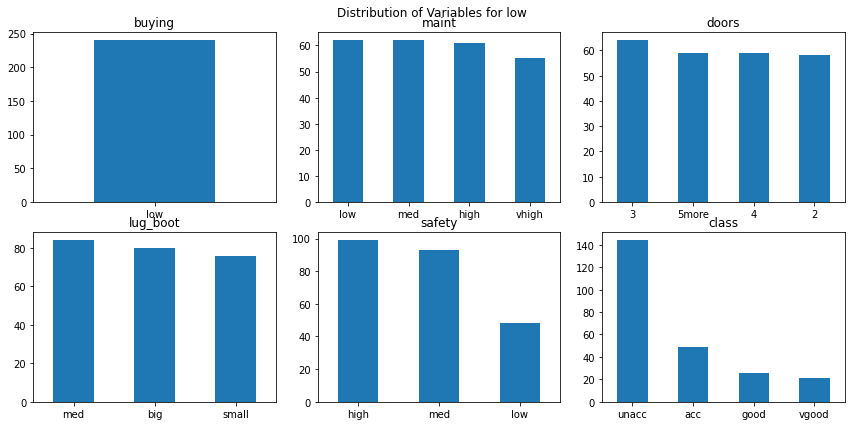

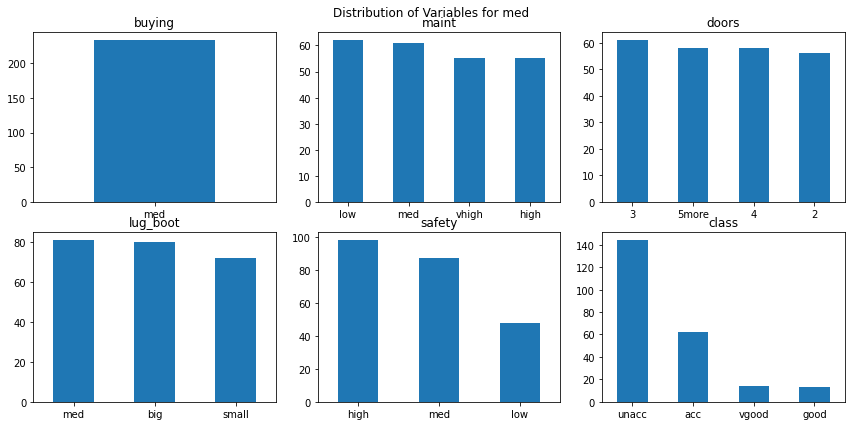

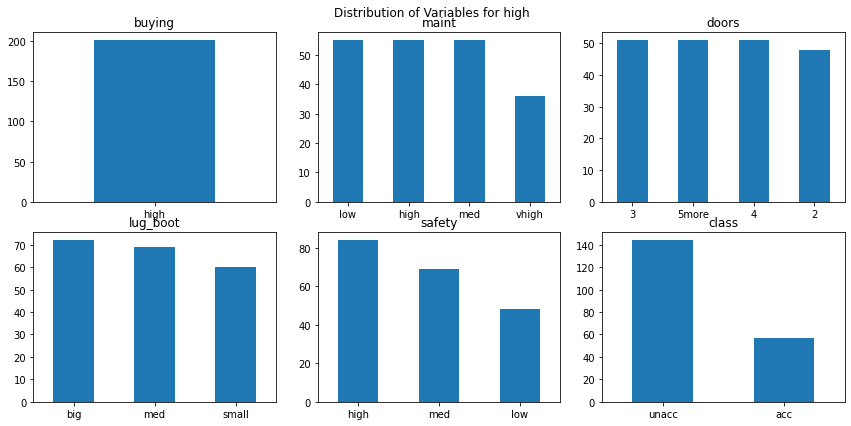

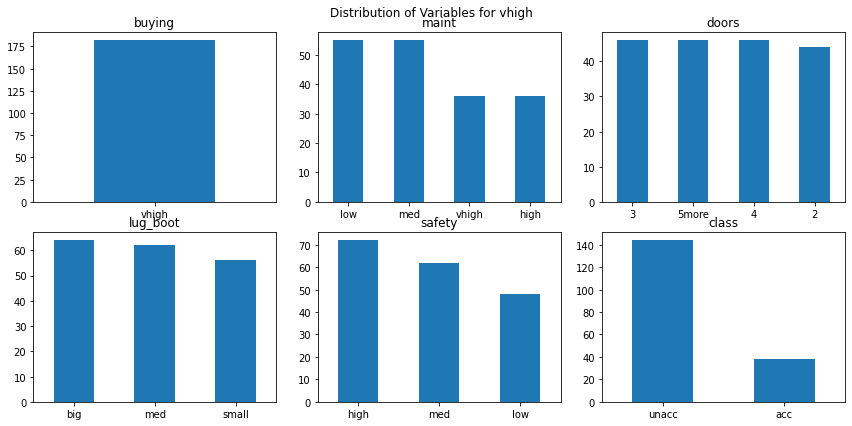

In [10]:
# Function to plot the distributions based on a filter rule
def plot_distributions(subset_rule, title):
    plot_data = data[subset_rule] 
    fig, ax = plt.subplots(2, 3, figsize=(12,6))
    fig.suptitle(f"Distribution of Variables for {title}")
    fig.tight_layout()
    fig.subplots_adjust(top=0.92)
    for i, categorical_feature in enumerate(data):
        plot = plot_data[categorical_feature].value_counts().plot(kind = "bar", ax=ax[i // 3][i % 3])
        plot.set_title(categorical_feature)
        plot.tick_params(axis='x', rotation=0)
    fig.show()

# Plot the distributions based on the different classes in buying
for buying_class in ["low", "med", "high", "vhigh"]:
    subset_rule = data["buying"] == buying_class
    plot_distributions(subset_rule, buying_class)

From the distribution plots it can be seen that only **class** is helpful for predicting **buying**, as all the other variables seem to have somewhat of the same distributions for each buying category. 

## 2.2 Chi-Square test of independence 


H0: Variables are independent <br>
HA: Variables are dependent <br>
Test on 95% confidence  

In [11]:
for col in data.columns:
    crosstab = pd.crosstab(data["buying"], data[col])
    print(crosstab)

    stat, p, dof, expected = chi2_contingency(crosstab)
    p_value_str = f"The P-value is {p}"
    if p <0.5:
        p_value_str += " which is lesser than 0.05, hence we can reject the null hypothesis."
    else:
        p_value_str += " which is more than 0.05, hence we cannot reject the null hypothesis."
    print(p_value_str)

    print("\n")

buying  high  low  med  vhigh
buying                       
high     201    0    0      0
low        0  240    0      0
med        0    0  233      0
vhigh      0    0    0    182
The P-value is 0.0 which is lesser than 0.05, hence we can reject the null hypothesis.


maint   high  low  med  vhigh
buying                       
high      55   55   55     36
low       61   62   62     55
med       55   62   61     55
vhigh     36   55   55     36
The P-value is 0.708986771322955 which is more than 0.05, hence we cannot reject the null hypothesis.


doors    2   3   4  5more
buying                   
high    48  51  51     51
low     58  64  59     59
med     56  61  58     58
vhigh   44  46  46     46
The P-value is 0.9999996172131111 which is more than 0.05, hence we cannot reject the null hypothesis.


lug_boot  big  med  small
buying                   
high       72   69     60
low        80   84     76
med        80   81     72
vhigh      64   62     56
The P-value is 0.9990873884003

Since all variables except for **class** seems to be _independent_ from buying.

## 2.3. EDA Conclusion 

We discovered that **class** is the only variable that is significant in predicting **buying**. However, it may also be possible that the other variables, in conjunction with **class** may help to provide better predictions, as they might not have the same distributions after conditioning for class. 

It would be tedious to eyeball every single combination, hence we will instead experiment later on section 4 to see if there is any performance gain for including the rest of the variables. If there is no significant performance gain, then I will opt to only keep **class** as the features. 

# 3 Feature Engineering

## 3.1 Encoding

**One-hot vs Ordinal Encoding**

Since all features are Ordinal i.e. _doors_ consists of the values [2, 3, 4, 5more]. <br>
Ordinal Encoding is prefered as it preserves some aspect of order while One-hot Encoding disregards the order of the categories.
Hence **Ordinal Encoding is chosen as the best encoding method** in this case.


In [12]:
data.columns

Index(['buying', 'maint', 'doors', 'lug_boot', 'safety', 'class'], dtype='object')

In [13]:
ordinal_encoding = {'buying': {"vhigh" : 4, "high" : 3, "med" : 2, "low": 1},
                  'maint': {"vhigh" : 4, "high" : 3, "med" : 2, "low": 1},
                  'doors': {"2" : 1, "3" : 2, "4" : 3, "5more": 4},
                  'persons': {"2" : 1, "4" : 2, "more" : 3},
                  'lug_boot': {"small" : 1, "med" : 2, "big": 3},
                  'safety': { "high" : 3, "med" : 2, "low": 1},
                  'class': {"unacc" : 1, "acc": 2, "good": 3, "vgood": 4}}

encoded_data = data.replace(ordinal_encoding)

# 4 Model Selection

## 4.1 Stratified Train Test Split

We stratify by **buying** to mantain the same proportion 

In [14]:
y = encoded_data["buying"]

**All Features**

In [15]:
# All Features
test_size = 0.15
random_state = 4
X = encoded_data.drop("buying", axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify = y)

[x.shape for x in [X_train, X_test, y_train, y_test]]

[(727, 5), (129, 5), (727,), (129,)]

In [16]:
y_train.value_counts() / len(y_train)

1   0.28
2   0.27
3   0.24
4   0.21
Name: buying, dtype: float64

In [17]:
y_test.value_counts() / len(y_test)

1   0.28
2   0.27
3   0.23
4   0.22
Name: buying, dtype: float64

**Class Only**

In [18]:
# Features - class only 
# These are marked with a _c 
X_c = encoded_data[["class"]]
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_c, y, test_size=test_size, random_state=random_state, stratify = y)
[x.shape for x in [X_train_c, X_test_c, y_train_c, y_test_c]]

[(727, 1), (129, 1), (727,), (129,)]

In [19]:
y_train_c.value_counts() / len(y_train_c)

1   0.28
2   0.27
3   0.24
4   0.21
Name: buying, dtype: float64

In [20]:
y_test_c.value_counts() / len(y_test_c)

1   0.28
2   0.27
3   0.23
4   0.22
Name: buying, dtype: float64

## 4.2 LazyPredict

**LazyPredict** is a library that quickly evaluates many different models based on the data. 

We can pick the best models here to inspect and tune further.

**All Features**

In [21]:
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train, X_test, y_train, y_test)

100%|██████████| 29/29 [00:05<00:00,  5.48it/s]


In [22]:
models

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
AdaBoostClassifier,0.32,0.32,None,0.32,0.11
Perceptron,0.31,0.31,None,0.28,0.02
CalibratedClassifierCV,0.28,0.27,None,0.27,0.20
SGDClassifier,0.27,0.26,None,0.23,0.03
DummyClassifier,0.25,0.25,None,0.24,0.01
PassiveAggressiveClassifier,0.26,0.24,None,0.17,0.02
LogisticRegression,0.24,0.24,None,0.22,0.03
LinearSVC,0.24,0.24,None,0.20,0.07
LinearDiscriminantAnalysis,0.24,0.23,None,0.22,0.03


**Class Only**

In [23]:
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train_c, X_test_c, y_train_c, y_test_c)

100%|██████████| 29/29 [00:04<00:00,  7.05it/s]


In [24]:
models

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
AdaBoostClassifier,0.26,0.28,None,0.22,0.47
GaussianNB,0.26,0.28,None,0.22,0.06
XGBClassifier,0.26,0.28,None,0.22,1.28
SVC,0.26,0.28,None,0.22,0.07
RandomForestClassifier,0.26,0.28,None,0.22,0.32
QuadraticDiscriminantAnalysis,0.26,0.28,None,0.22,0.02
BaggingClassifier,0.26,0.28,None,0.22,0.06
LabelSpreading,0.26,0.28,None,0.22,0.11
LabelPropagation,0.26,0.28,None,0.22,0.06


While there is no performance gain in terms of Accuracy for using All Features, there is a gain for F1-Score.  

We should investigate this further by looking at the confusion matrix. 

Note: The lazy prediction results varied wildly depending on different seeds. This might have be because we dont have much data to work with after we dropped the duplicates. 

Furthermore, the variables used for this model are likely not very useful at predicting **Buying**. We see this as the dummyclassifier is not so far off from the best models (suggesting the best models are not that much better than just predicting the majority class).

We will choose adaboost as the model to do this as it seems to be the one of the best classifier in terms of accuracy (and we are familiar with it)

**All Features**

In [25]:
def print_scores(true, pred, title):
    acc = accuracy_score(true, pred)
    f1 = f1_score(true, pred, average = "macro")
    print(f"{title} Acc: {acc} F1: {f1}")

def get_clf_scores(clf, X_train, y_train, X_test, y_test):
    train_pred = clf.predict(X_train)
    test_pred = clf.predict(X_test)
    print_scores(y_train, train_pred, "Train")
    print_scores(y_test, test_pred, "Test")

In [26]:
clf = AdaBoostClassifier()
clf.fit(X_train, y_train)

get_clf_scores(clf, X_train, y_train, X_test, y_test)

Train Acc: 0.3177441540577717 F1: 0.3120927122648831
Test Acc: 0.3178294573643411 F1: 0.31233211874897815


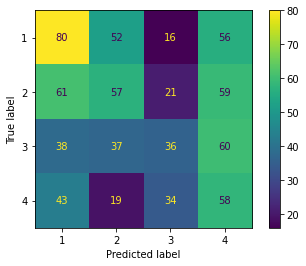

In [27]:
plot_confusion_matrix(clf, X_train, y_train)

**Only Class**

In [28]:
clf = AdaBoostClassifier()
clf.fit(X_train_c, y_train_c)

get_clf_scores(clf, X_train_c, y_train_c, X_test_c, y_test_c)

Train Acc: 0.3012379642365887 F1: 0.24475765500217467
Test Acc: 0.26356589147286824 F1: 0.21604506604506607


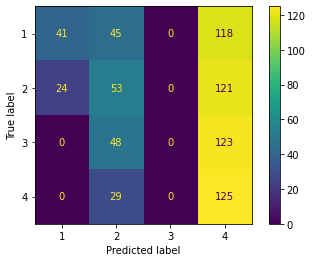

In [29]:
plot_confusion_matrix(clf, X_train_c, y_train_c)

We see that using **only class** resulting in the 2nd and 4th label not being predicted at all. Likely because class only has 4 unique values.

The using **All Features** may result in all 4 types of labels, but whether or not this is valid is not clear. 

For this challenge in particular, I believe it might be wiser to use **All Features** as the prediction can be of any label (may be different from 1 and 3). 

One other point to note in this section is that the _Dummy Classifier_ has an accuracy of 0.25 which is very close to Adaboost's 0.32. Suggesting that random guessing might perform similar to the model (Which is a bad thing.)

Regardless, we will following through with the procedure and can only hope for the best that the model will be able to make better predictions than random guessing.

## 4.3 Hyper parameter tuning

In this section we will gridsearch the parameters for adaboost.

In [30]:


skfold = StratifiedKFold(n_splits=5, shuffle = True, random_state = 0)

param_grid = {"base_estimator":[DecisionTreeClassifier()],
              "base_estimator__max_depth" : [2,3,4,5],
              "base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "algorithm" : ["SAMME","SAMME.R"],
              "n_estimators" :[5, 10, 20, 50],
              "learning_rate":  [0.001, 0.01, 0.05, 0.1],
              "random_state": [0]}

optimal_clf = GridSearchCV(estimator=AdaBoostClassifier(),
             param_grid=param_grid,
             cv = skfold,
             verbose = 1)

%time optimal_clf.fit(X_train, y_train)
optimal_clf.best_estimator_

Fitting 5 folds for each of 512 candidates, totalling 2560 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


CPU times: user 1min 59s, sys: 656 ms, total: 1min 59s
Wall time: 2min 4s


[Parallel(n_jobs=1)]: Done 2560 out of 2560 | elapsed:  2.1min finished


AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(criterion='entropy',
                                                         max_depth=2),
                   learning_rate=0.05, n_estimators=20, random_state=0)

In [31]:
get_clf_scores(optimal_clf, X_train, y_train, X_test, y_test)

Train Acc: 0.31361760660247595 F1: 0.25008282128727477
Test Acc: 0.3023255813953488 F1: 0.2397202964379632


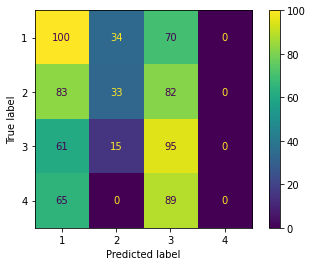

In [32]:
plot_confusion_matrix(optimal_clf, X_train, y_train)

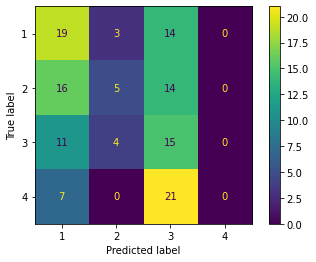

In [33]:
plot_confusion_matrix(optimal_clf, X_test, y_test)

**Fit on Full data**

In [34]:
final_clf = optimal_clf.best_estimator_
final_clf.fit(X,y)

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(criterion='entropy',
                                                         max_depth=2),
                   learning_rate=0.05, n_estimators=20, random_state=0)

In [35]:
final_clf.score(X,y)

0.3119158878504673

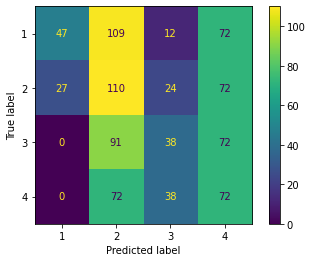

In [36]:
plot_confusion_matrix(optimal_clf, X, y)

# 5 Final Prediction

Maintenance = High <br>
Number of doors = 4<br>
Lug Boot Size = Big<br>
Safety = High<br>
Class Value = Good<br>

In [37]:
ordinal_encoding = {'buying': {"vhigh" : 4, "high" : 3, "med" : 2, "low": 1},
                  'maint': {"vhigh" : 4, "high" : 3, "med" : 2, "low": 1},
                  'doors': {"2" : 1, "3" : 2, "4" : 3, "5more": 4},
                  'persons': {"2" : 1, "4" : 2, "more" : 3},
                  'lug_boot': {"small" : 1, "med" : 2, "big": 3},
                  'safety': { "high" : 3, "med" : 2, "low": 1},
                  'class': {"unacc" : 1, "acc": 2, "good": 3, "vgood": 4}}


X_new = {"maint": 3,
         "doors" : 3,
         "lug_boot": 3,
         "safety": 3,
         "class": 3}
X_new = pd.Series(X_new)

In [38]:
optimal_clf.predict([X_new])

array([1])

The Prediction by our model is 1 --> low buying price.